# <div style="text-align: center"> Kaggle : Dogs vs Cats </div>
### <div style="text-align: center"> Create an algorithm to distinguish dogs from cats </div>

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/media/woof_meow.jpg" align ="middle">

### <div style="text-align:center"> Kernel By: <b> Kamal Chouhbi</b></div>

## 1- Introduction

In this competition, you'll write an algorithm to classify whether images contain either a dog or a cat.  This is easy for humans, dogs, and cats. Your computer will find it a bit more difficult.

<img src="https://storage.googleapis.com/kaggle-competitions/kaggle/3362/logos/front_page.png" align="middle">

 ## 2- Load packages

In [ ]:
import numpy as np
import pandas as pd
import os

from sklearn.model_selection import train_test_split
import random
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

Using TensorFlow backend.


2.0.0


## 3- Preparing Data

In [ ]:
import zipfile
z = zipfile.ZipFile('../input/dogs-vs-cats/train.zip', 'r')
z.extractall(path=r"./")
z.close()
z = zipfile.ZipFile('../input/dogs-vs-cats/test1.zip', 'r')
z.extractall(path=r"./")
z.close()

UsageError: Line magic function `%` not found.


In [ ]:
training_images = "/kaggle/working/train"
test_images = "/kaggle/working/test1"

train_size = len([name for name in os.listdir(training_images)])
test_size = len([name for name in os.listdir(test_images)])
print("Number of training images:", train_size)
print("Number of test images:", test_size)

Number of training images: 25000
Number of test images: 12500


In [ ]:
IMAGE_WIDTH = IMAGE_HEIGHT = 150

### Prepare Training Data

In [ ]:
filenames = os.listdir(training_images)
categories = []

Valid_Fraction = 0.2
Batch_Size = 100
Epochs = 100

for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)
categories = [str(i) for i in categories]
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [ ]:
df.head()

,filename,category
0,cat.4745.jpg,0
1,dog.3992.jpg,1
2,cat.9877.jpg,0
3,cat.11275.jpg,0
4,cat.8771.jpg,0


In [ ]:
type(df['category'][0])

str

In [ ]:
df.tail()

,filename,category
24995,dog.5450.jpg,1
24996,cat.3443.jpg,0
24997,cat.10705.jpg,0
24998,cat.11437.jpg,0
24999,cat.12434.jpg,0


In [ ]:
df['category'].value_counts()

0    12500
1    12500
Name: category, dtype: int64

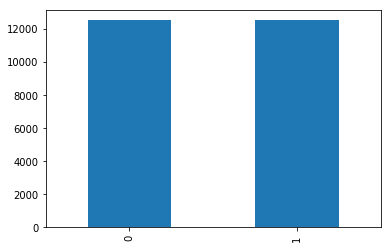

In [ ]:
df['category'].value_counts().plot.bar()

From our data we have 12500 cats and 12500 dogs, so our data is balanced. Good !

### See sample image

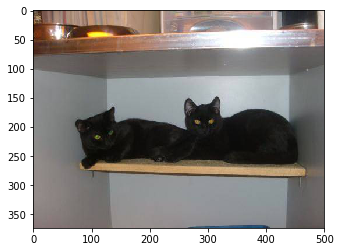

In [ ]:
sample = random.choice(filenames)
image = load_img("../input/dogs-vs-cats/train/train/"+sample)
plt.imshow(image)

In [ ]:
# splitting to train & valid
train_df, valid_df = train_test_split(df, test_size=Valid_Fraction, random_state=10)

## 4- Traning Generator

- Creating train and valid generators (not using valid_split to avoid doing data augmentation on validation set)

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    training_images, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=Batch_Size
)

Found 20000 validated image filenames belonging to 2 classes.


### Validation Generator

In [ ]:
# not doing any data augmentation on validation test set
valid_datagen  = ImageDataGenerator(rescale=1./255.)

validation_generator = valid_datagen.flow_from_dataframe(
    valid_df, 
    training_images, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=Batch_Size
)

Found 5000 validated image filenames belonging to 2 classes.


### See how our generator work

In [ ]:
example_df = train_df.sample(n=20).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    training_images, 
    x_col='filename',
    y_col='category',
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode='binary',
    batch_size=Batch_Size
)

Found 20 validated image filenames belonging to 2 classes.


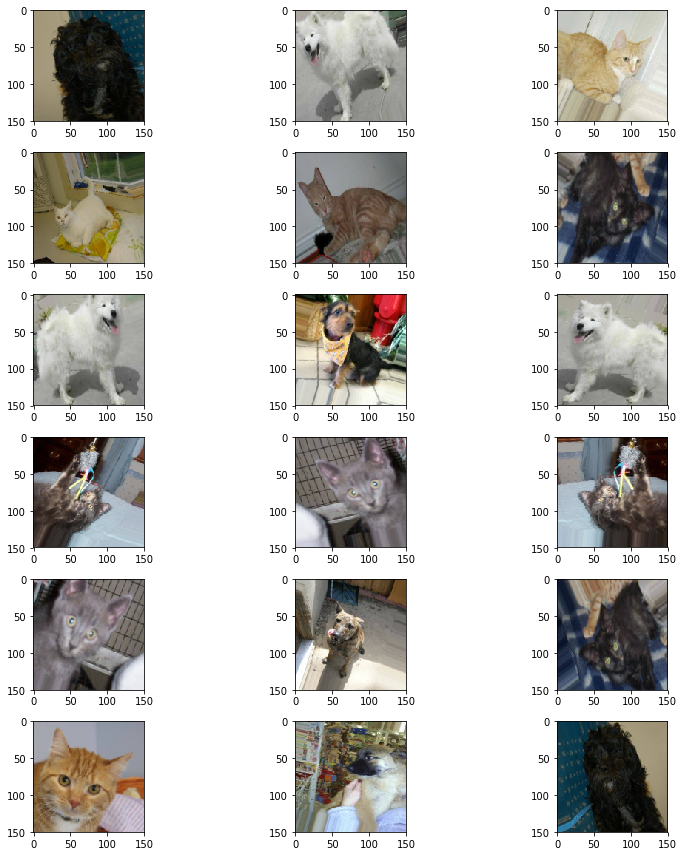

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 18):
    plt.subplot(6, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
        
plt.tight_layout()
plt.show()

## 5- Building Model

In [ ]:
model = tf.keras.models.Sequential([
    # the images were resized by ImageDataGenerator 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    # since we have only 2 classes to predict we can use 1 neuron and sigmoid
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.summary()

model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.001),
    loss='binary_crossentropy',
    metrics = ['accuracy'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 148, 148, 32)      128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 72, 72, 64)        256       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)       

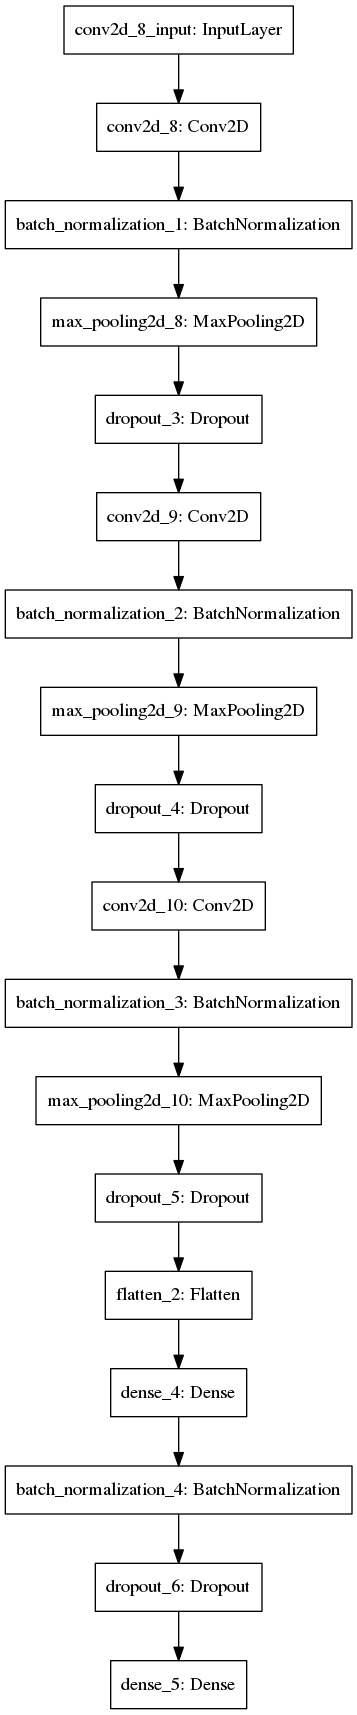

In [ ]:
tf.keras.utils.plot_model(model)

### Callbacks

#### Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
    mode='min',
    restore_best_weights=True, 
    patience=10)

## Training

### Model

In [ ]:
total_validate = int(valid_df.count()[0])
total_train = int(train_df.count()[0])

In [ ]:
history = model.fit_generator(
    train_generator, 
    epochs=Epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//Batch_Size,
    steps_per_epoch=total_train//Batch_Size,
    callbacks=[es]
)

Epoch 1/3
200/200 [==============================] - 196s 979ms/step - loss: 0.7412 - accuracy: 0.6331 - val_loss: 1.1787 - val_accuracy: 0.4912
Epoch 2/3
200/200 [==============================] - 166s 828ms/step - loss: 0.5506 - accuracy: 0.7281 - val_loss: 0.8619 - val_accuracy: 0.5380
Epoch 3/3
200/200 [==============================] - 165s 826ms/step - loss: 0.4744 - accuracy: 0.7749 - val_loss: 1.1134 - val_accuracy: 0.6336


### Save Model

In [ ]:
model.save_weights("model.h5")

### Virtualize Training

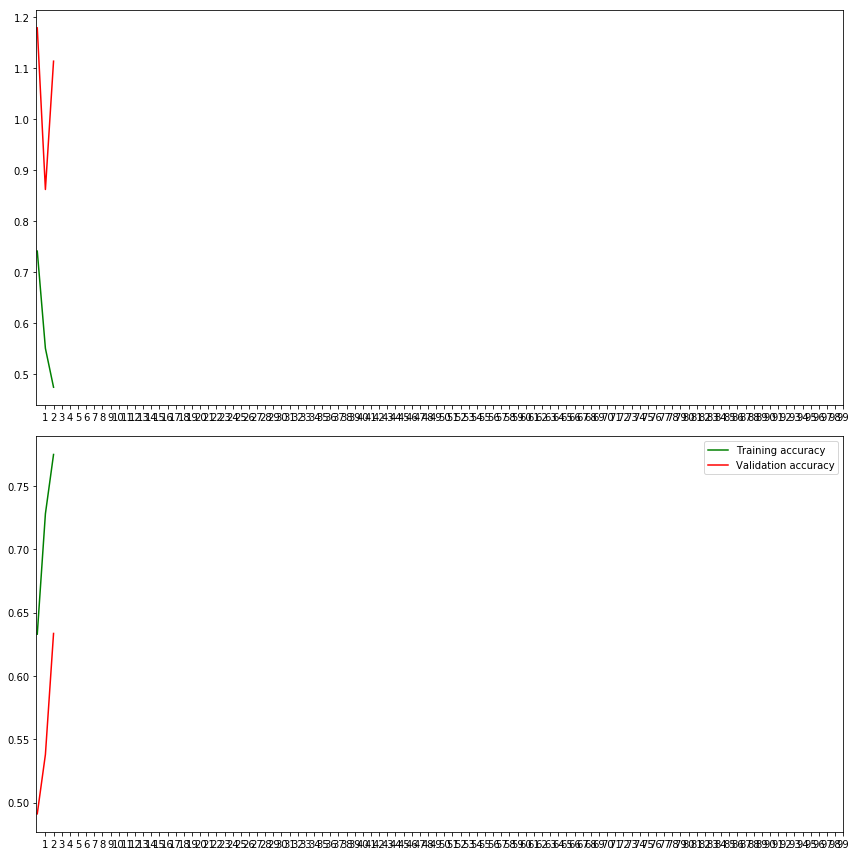

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------

ax1.plot(history.history['loss'], color='g', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, Epochs, 1))

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------

ax2.plot(history.history['accuracy'], color='g', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, Epochs, 1))

legend = plt.legend()
plt.tight_layout()
plt.show()

### Create Testing Generator

In [ ]:
test_filenames = os.listdir(test_images)
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(rescale=1./255)

test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_images, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size=Batch_Size,
    shuffle=False
)

Found 12500 validated image filenames.


 ### Prediction

In [ ]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/Batch_Size))
predict

As predicted of binary classification result return probability that image likely to be a dog. So we will have threshold 0.5 which mean if predicted value more than 50% it is a dog and under 50% will be a cat.

In [ ]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

### Virtaulize Result

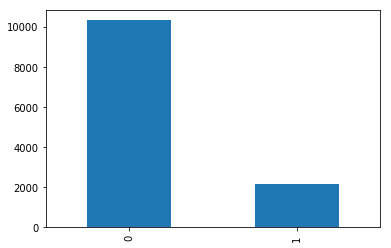

In [ ]:
test_df['category'].value_counts().plot.bar()

### See predicted result with images

In [ ]:
sample_test.category[0] == 0

True

In [ ]:
sample_test = test_df.head(10)
for i in range(sample_test.count()[0]):
    if (sample_test.category[i] == 1):
          sample_test['Animal'] = 'dog'
    else: 
            sample_test['Animal'] = 'cat'
sample_test.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,filename,probability,category,Animal
0,10550.jpg,0.027234,0,cat
1,11840.jpg,0.021143,0,cat
2,6842.jpg,0.143854,0,cat
3,10646.jpg,0.047141,0,cat
4,10394.jpg,0.072037,0,cat


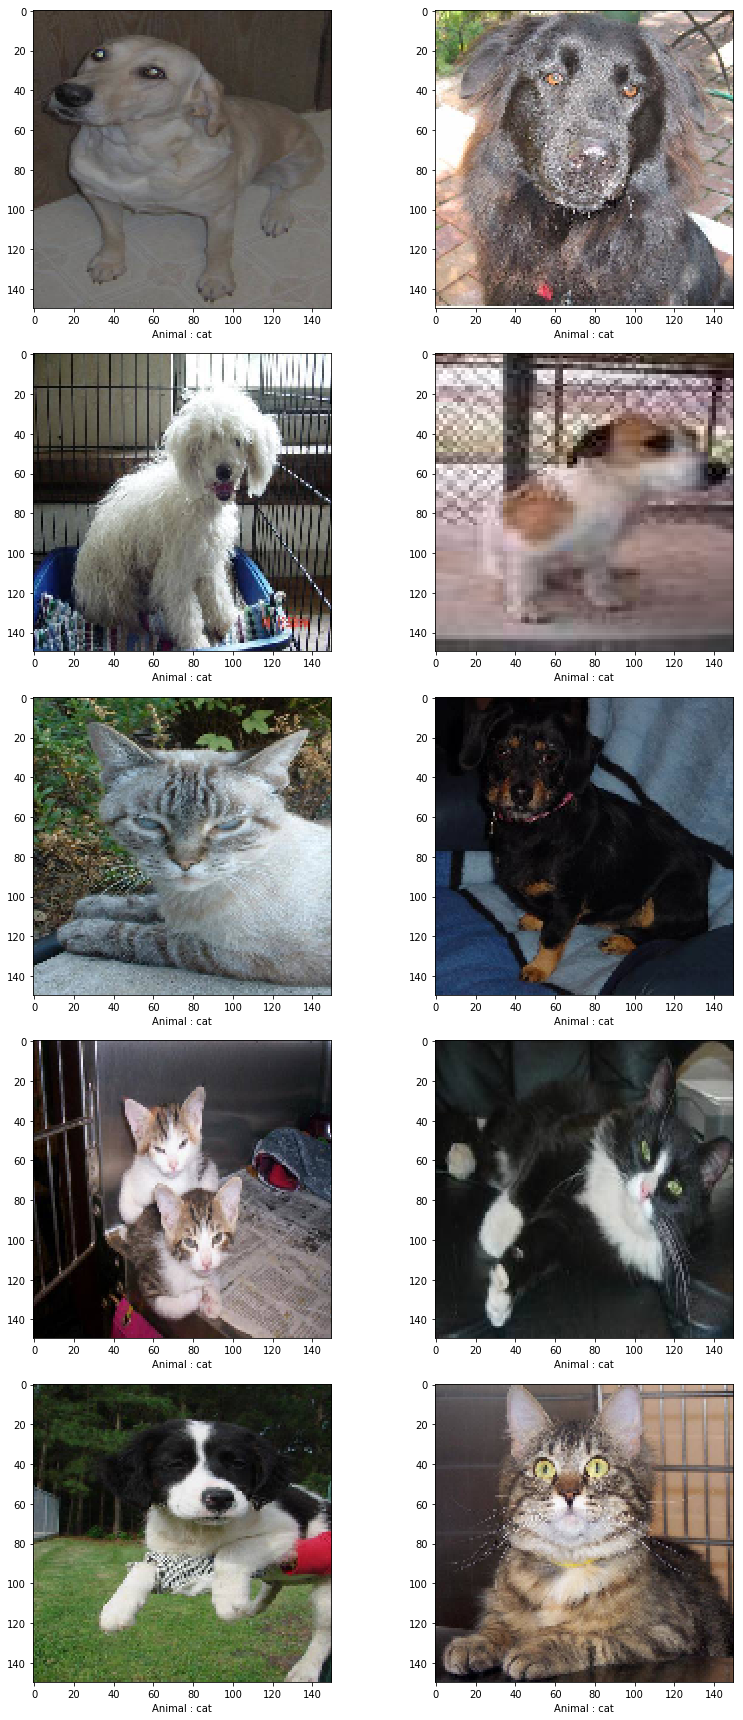

In [ ]:
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['Animal']
    img = load_img("../input/dogs-vs-cats/test1/test1/"+filename, target_size=(IMAGE_WIDTH,IMAGE_HEIGHT))
    plt.subplot(5, 2, index+1)
    plt.imshow(img)
    plt.xlabel("Animal : " + category)
plt.tight_layout()
plt.show()

### Submission

In [ ]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category', 'probability'], axis=1, inplace=True)
submission_df

,id,label
0,10550,0
1,11840,0
2,6842,0
3,10646,0
4,10394,0
...,...,...
12495,3472,0
12496,4871,1
12497,7269,0
12498,6718,0


In [ ]:
submission_df.to_csv('submission.csv', index=False)